# Farmers Markets Regression Analysis with Machine Learning
This dataset was posted on [Kaggle](https://www.kaggle.com/madeleineferguson/farmers-markets-in-the-united-states).
* The original source of the farmers market data was the [US Department of Agriculture](https://www.ams.usda.gov/local-food-directories/farmersmarkets).
* The original source of the income and population data was the US Census Bureau via [Wikipedia](https://en.wikipedia.org/wiki/List_of_United_States_counties_by_per_capita_income)

The regression analysis below shows the level of correlation among the number of farmers markets by county versus income and population of that county. 
* The purpose of this analysis is to bring forth these correlations.
* This correlation cannot be used to evaluate whether more farmers markets would thrive in areas with less existing markets.  Some complexities that would obsfuscate such an evaluation are differences in the sizes of markets, number of vendors, number of shoppers, and other local food options by area.  Yet the regression and model identigy a good starting point for prioritize which areas to look into first.

The machine learning models predict the number of farmers markets by county using the income and population features of that county.

The question that the models attempt to provide insights towards is, "Is this market (county) oversaturated with farmers markets or would adding more farmers markets be feasible?"  Additonally, I am interested in finding data about how successful these farmers markets are, the number of vendors at each market, etc. Please reach out to me on twitter @tourofdata if you know where to find this data!  Otherwise, I'll search every so often.

In [1]:
import numpy as np
import pandas as pd 
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# import farmers markets data
df = pd.read_csv('farmers_markets_from_usda.csv')

In [3]:
# inspect the data to determine which columns to keep
df.head(2)

,FMID,MarketName,Website,Facebook,Twitter,Youtube,OtherMedia,street,city,County,...,Coffee,Beans,Fruits,Grains,Juices,Mushrooms,PetFood,Tofu,WildHarvested,updateTime
0,1018261,Caledonia Farmers Market Association - Danville,https://sites.google.com/site/caledoniafarmers...,https://www.facebook.com/Danville.VT.Farmers.M...,NaN,NaN,NaN,NaN,Danville,Caledonia,...,Y,Y,Y,N,N,Y,Y,N,N,6/20/2017 22:43
1,1018318,Stearns Homestead Farmers' Market,http://www.StearnsHomestead.com,StearnsHomesteadFarmersMarket,NaN,NaN,NaN,6975 Ridge Road,Parma,Cuyahoga,...,N,N,Y,N,N,N,N,N,N,6/21/2017 17:15


In [4]:
# how many records of data?
df.shape

(8804, 59)

In [5]:
# choose the fields to keep for analysis
df_market = df[['city','County','State','zip']].copy()
df_market_random = df_market.reindex(np.random.permutation(df_market.index))
df_market_random

,city,County,State,zip
5049,"Washington, DC",District of Columbia,District of Columbia,20019
1860,Smithville,DeKalb,Tennessee,37199
8549,Whitestown,Boone,Indiana,46075
930,Brooklyn,Kings,New York,11237
3527,Hemlock,Saginaw,Michigan,48626
...,...,...,...,...
6908,Seymour,New Haven,Connecticut,6483
8652,Madison,Dane,Wisconsin,53703
5033,Milton,Sussex,Delaware,19968
637,Westerville,Franklin,Ohio,43081


In [6]:
# Null / NaN records - Any of the columns except State may be null
df_market.isnull().any()

city       True
County     True
State     False
zip        True
dtype: bool

In [7]:
# A better look to inspect Null / NaN records
df_market[df_market.isna().any(axis=1)].head(50)

,city,County,State,zip
1,Parma,Cuyahoga,Ohio,NaN
37,Loveland,Larimer,Colorado,NaN
45,Dothan,Houston,Alabama,NaN
55,Abbeville,Henry,Alabama,NaN
57,Minneapolis,Hennepin,Minnesota,NaN
64,Clarks Summit,Lackawanna,Pennsylvania,NaN
66,Albququerque,Bernalillo,New Mexico,NaN
68,Town Hill,Hancock,Maine,NaN
70,Rome,Oneida,New York,NaN
75,Acworth,Cobb,Georgia,NaN


In [8]:
# records by state, Nulls aren't too significant for any state if all NaN counties are dropped
# a more thorough process would be to fill-in/correct data
df_market.groupby('State').agg('count')

,city,County,zip
State,,,
Alabama,138,138,133
Alaska,37,37,32
Arizona,93,93,85
Arkansas,110,111,103
California,753,755,616
Colorado,161,159,112
Connecticut,158,158,109
Delaware,36,35,34
District of Columbia,60,60,57


In [9]:
# as mentioned above, for now just drop all rows where County = NaN
df_market = df_market[df_market['County'].notna()]
df_market.isnull().any()

city       True
County    False
State     False
zip        True
dtype: bool

In [10]:
df_market = df_market.dropna(subset=['County'], inplace=False)
df_market.shape

(8768, 4)

In [11]:
# number of rows dropped
df.shape[0]-df_market.shape[0] 

36

In [12]:
# farmers market data is ready
df_market[df_market.isna().any(axis=1)].head(50)
#pd.set_option('display.max_rows', None)
#df_market[df_market['State']=='kentucky'].head(70)

,city,County,State,zip
1,Parma,Cuyahoga,Ohio,NaN
37,Loveland,Larimer,Colorado,NaN
45,Dothan,Houston,Alabama,NaN
55,Abbeville,Henry,Alabama,NaN
57,Minneapolis,Hennepin,Minnesota,NaN
64,Clarks Summit,Lackawanna,Pennsylvania,NaN
66,Albququerque,Bernalillo,New Mexico,NaN
68,Town Hill,Hancock,Maine,NaN
70,Rome,Oneida,New York,NaN
75,Acworth,Cobb,Georgia,NaN


## Calculate the number of farmers markets by county

In [13]:
df_market['County'] = df_market['County'].str.lower()
df_market['State'] = df_market['State'].str.lower()
df_market['Markets'] = 1
df_market_county_state = df_market[['County','State','Markets']]
df_market_county_state_count = df_market_county_state.groupby(['County','State']).agg('count')
df_market_county_state_count.head(15)
# fyi, clarifying the printout below, adair county exists in iowa, kentucky, and missouri

Markets
County       State                  
abbeville    south carolina        2
accomack     virginia              3
ada          idaho                 7
adair        iowa                  1
             kentucky              1
             missouri              1
adair county kentucky              1
adams        colorado              7
             illinois              3
             indiana               1
             iowa                  1
             nebraska              2
             north dakota          1
             ohio                  1
             pennsylvania          2

## Combine the other feature data for the counties

In [14]:
# import county feature dates, no duplicates for counties as long as State is also included
df_county = pd.read_csv('farmers_markets_wiki_county_info.csv')
df_county[df_county['county'] == 'Johnson']

,number,county,State,per capita income,median household income,median family income,population,number of households
52,53,Johnson,Kansas,"$38,827","$74,717","$92,512","552,947","216,304"
358,357,Johnson,Iowa,"$29,592","$53,424","$79,964","134,034","54,005"
436,435,Johnson,Indiana,"$28,575","$61,231","$73,059","141,796","52,239"
486,485,Johnson,Wyoming,"$28,072","$57,004","$63,343","8,595","3,679"
1089,1087,Johnson,Texas,"$24,816","$57,535","$65,392","152,384","52,044"
1946,1942,Johnson,Missouri,"$21,547","$47,223","$58,641","53,517","20,092"
2477,2471,Johnson,Kentucky,"$19,445","$34,090","$41,981","23,377","9,154"
2481,2475,Johnson,Nebraska,"$19,435","$42,364","$53,932","5,182","1,926"
2499,2493,Johnson,Arkansas,"$19,366","$31,003","$37,119","25,655","10,046"
2641,2634,Johnson,Illinois,"$18,763","$40,760","$50,796","12,665","4,362"


In [15]:
# view_nulls
df_county[df_county.isna().any(axis=1)]

,number,county,State,per capita income,median household income,median family income,population,number of households
96,NaN,NaN,Maryland,"$36,354","$73,538","$88,738","5,834,299","2,146,240"
105,NaN,NaN,New Jersey,"$36,027","$71,629","$87,347","8,832,406","3,186,418"
2205,30%,NaN,NaN,"$20,530",NaN,NaN,NaN,NaN
2522,20%,NaN,NaN,"$19,280",NaN,NaN,NaN,NaN
3152,NaN,NaN,Puerto Rico,"$12,081","$19,775","$23,793","3,195,153","1,222,606"


In [16]:
# drop nulls 
df_county = df_county.dropna(subset=['county','State'], inplace=False)
df_county.isnull().any()

number                     False
county                     False
State                      False
per capita income          False
median household income    False
median family income       False
population                 False
number of households       False
dtype: bool

In [17]:
df_county['county'] = df_county['county'].str.lower()
df_county['State'] = df_county['State'].str.lower()
df_county.head(3)

,number,county,State,per capita income,median household income,median family income,population,number of households
0,1,new york county,new york,"$62,498","$69,659","$84,627","1,605,272","736,192"
1,2,arlington,virginia,"$62,018","$103,208","$139,244","214,861","94,454"
2,3,falls church city,virginia,"$59,088","$120,000","$152,857","12,731","5,020"


In [18]:
df_market_county = df_market_county_state.merge(df_county, left_on = ['County','State'], \
                                    right_on = ['county','State'], \
                                    how = 'inner')
df_market_county.shape

(8160, 10)

In [19]:
# since 8160 rows is less than 8768 rows, the join filtered out some data
# without shifting to lowercase, an additional 15 rows would have been dropped
# for the (8768 - 8160) rows that were dropped, 
        # a more detailed step could be to understand why these were dropped
        # https://stackoverflow.com/questions/34296292/pandas-dropna-store-dropped-rows
df_market_county.head(10)

,County,State,Markets,number,county,per capita income,median household income,median family income,population,number of households
0,caledonia,vermont,1,1391,caledonia,"$23,584","$45,395","$54,941","31,157","12,491"
1,caledonia,vermont,1,1391,caledonia,"$23,584","$45,395","$54,941","31,157","12,491"
2,caledonia,vermont,1,1391,caledonia,"$23,584","$45,395","$54,941","31,157","12,491"
3,caledonia,vermont,1,1391,caledonia,"$23,584","$45,395","$54,941","31,157","12,491"
4,caledonia,vermont,1,1391,caledonia,"$23,584","$45,395","$54,941","31,157","12,491"
5,caledonia,vermont,1,1391,caledonia,"$23,584","$45,395","$54,941","31,157","12,491"
6,caledonia,vermont,1,1391,caledonia,"$23,584","$45,395","$54,941","31,157","12,491"
7,caledonia,vermont,1,1391,caledonia,"$23,584","$45,395","$54,941","31,157","12,491"
8,cuyahoga,ohio,1,576,cuyahoga,"$27,423","$43,804","$59,745","1,272,533","534,476"
9,cuyahoga,ohio,1,576,cuyahoga,"$27,423","$43,804","$59,745","1,272,533","534,476"


In [20]:
df = df_market_county.groupby(['County','State','per capita income','median household income', \
                          'median family income', 'population','number of households']).count()
print(type(df))
df

<class 'pandas.core.frame.DataFrame'>


Markets  \
County    State          per capita income median household income median family income population number of households            
abbeville south carolina $18,134           $35,947                 $47,211              25,233     9,809                       2   
accomack  virginia       $22,703           $39,328                 $48,708              33,289     14,333                      3   
ada       idaho          $27,452           $55,210                 $67,641              401,673    151,600                     7   
adair     iowa           $25,564           $47,892                 $60,232              7,588      3,295                       1   
          kentucky       $17,371           $32,524                 $45,463              18,696     7,241                       1   
...                                                                                                                          ...   
york      nebraska       $28,207           $49,633                 $63,940              13,762     5,501                       1   
          pennsylvania   $28,132           $58,745                 $70,001              436,339    167,592                     9   
          south carolina $26,553           $53,740                 $66,256              230,934    86,483                      4   
          virginia       $36,373           $82,073                 $95,392              65,762     24,071                      1   
yuba      california     $19,244           $44,902                 $50,648              72,574     24,300                      2   

                                                                                                                         number  \
County    State          per capita income median household income median family income population number of households           
abbeville south carolina $18,134           $35,947                 $47,211              25,233     9,809                      2   
accomack  virginia       $22,703           $39,328                 $48,708              33,289     14,333                     3   
ada       idaho          $27,452           $55,210                 $67,641              401,673    151,600                    7   
adair     iowa           $25,564           $47,892                 $60,232              7,588      3,295                      1   
          kentucky       $17,371           $32,524                 $45,463              18,696     7,241                      1   
...                                                                                                                         ...   
york      nebraska       $28,207           $49,633                 $63,940              13,762     5,501                      1   
          pennsylvania   $28,132           $58,745                 $70,001              436,339    167,592                    9   
          south carolina $26,553           $53,740                 $66,256              230,934    86,483                     4   
          virginia       $36,373           $82,073                 $95,392              65,762     24,071                     1   
yuba      california     $19,244           $44,902                 $50,648              72,574     24,300                     2   

                                                                                                                         county  
County    State          per capita income median household income median family income population number of households          
abbeville south carolina $18,134           $35,947                 $47,211              25,233     9,809                      2  
accomack  virginia       $22,703           $39,328                 $48,708              33,289     14,333                     3  
ada       idaho          $27,452           $55,210                 $67,641              401,673    151,600                    7  
adair     iowa           $25,564           $47,892

In [21]:
df = df.reset_index(level=['per capita income','median household income', \
                          'median family income', 'population','number of households'])
df

per capita income median household income  \
County    State                                                      
abbeville south carolina          $18,134                 $35,947    
accomack  virginia                $22,703                 $39,328    
ada       idaho                   $27,452                 $55,210    
adair     iowa                    $25,564                 $47,892    
          kentucky                $17,371                 $32,524    
...                                    ...                     ...   
york      nebraska                $28,207                 $49,633    
          pennsylvania            $28,132                 $58,745    
          south carolina          $26,553                 $53,740    
          virginia                $36,373                 $82,073    
yuba      california              $19,244                 $44,902    

                         median family income population number of households  \
County    State                                                                 
abbeville south carolina             $47,211      25,233                9,809   
accomack  virginia                   $48,708      33,289               14,333   
ada       idaho                      $67,641     401,673              151,600   
adair     iowa                       $60,232       7,588                3,295   
          kentucky                   $45,463      18,696                7,241   
...                                       ...        ...                  ...   
york      nebraska                   $63,940      13,762                5,501   
          pennsylvania               $70,001     436,339              167,592   
          south carolina             $66,256     230,934               86,483   
          virginia                   $95,392      65,762               24,071   
yuba      california                 $50,648      72,574               24,300   

                          Markets  number  county  
County    State                                    
abbeville south carolina        2       2       2  
accomack  virginia              3       3       3  
ada       idaho                 7       7       7  
adair     iowa                  1       1       1  
          kentucky              1       1       1  
...                           ...     ...     ...  
york      nebraska              1       1       1  
          pennsylvania          9       9       9  
          south carolina        4       4       4  
          virginia              1       1       1  
yuba      california            2       2       2  

[2211 rows x 8 columns]

In [22]:
df.dtypes # need to convert the objects with '$' and ',' into integers
df[df.columns[0:]] = df[df.columns[0:]].replace('[\$,]', '', regex=True).astype(int)
df

per capita income  median household income  \
County    State                                                        
abbeville south carolina              18134                    35947   
accomack  virginia                    22703                    39328   
ada       idaho                       27452                    55210   
adair     iowa                        25564                    47892   
          kentucky                    17371                    32524   
...                                     ...                      ...   
york      nebraska                    28207                    49633   
          pennsylvania                28132                    58745   
          south carolina              26553                    53740   
          virginia                    36373                    82073   
yuba      california                  19244                    44902   

                          median family income  population  \
County    State                                              
abbeville south carolina                 47211       25233   
accomack  virginia                       48708       33289   
ada       idaho                          67641      401673   
adair     iowa                           60232        7588   
          kentucky                       45463       18696   
...                                        ...         ...   
york      nebraska                       63940       13762   
          pennsylvania                   70001      436339   
          south carolina                 66256      230934   
          virginia                       95392       65762   
yuba      california                     50648       72574   

                          number of households  Markets  number  county  
County    State                                                          
abbeville south carolina                  9809        2       2       2  
accomack  virginia                       14333        3       3       3  
ada       idaho                         151600        7       7       7  
adair     iowa                            3295        1       1       1  
          kentucky                        7241        1       1       1  
...                                        ...      ...     ...     ...  
york      nebraska                        5501        1       1       1  
          pennsylvania                  167592        9       9       9  
          south carolina                 86483        4       4       4  
          virginia                       24071        1       1       1  
yuba      california                     24300        2       2       2  

[2211 rows x 8 columns]

In [23]:
df.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
per capita income,2211.0,24013.798281,5775.507878,7047.0,20425.0,23342.0,26742.5,62018.0
median household income,2211.0,46701.349616,12630.786446,11680.0,38991.0,44842.0,52416.5,122238.0
median family income,2211.0,57670.868385,14544.216421,13582.0,48614.0,55848.0,64632.5,139244.0
population,2211.0,129879.385798,368705.581242,711.0,17648.5,37942.0,99795.0,9893481.0
number of households,2211.0,48093.743555,128834.978113,330.0,6952.0,14679.0,37740.0,3230383.0
Markets,2211.0,3.690638,6.390264,1.0,1.0,2.0,4.0,128.0
number,2211.0,3.690638,6.390264,1.0,1.0,2.0,4.0,128.0
county,2211.0,3.690638,6.390264,1.0,1.0,2.0,4.0,128.0


## The Linear Regression Machine Learning Model

In [24]:
features = ['per capita income',
            'median household income', 
            'median family income', 
            'population',
            'number of households']

In [25]:
# pearson's correlation 
# correlations = [ df['Markets'].corr(df[f]) for f in features ] 
for f in features:
    correlation = df['Markets'].corr(df[f])
    print('%s' % f.ljust(30) + '%f' % correlation) 

per capita income             0.347484
median household income       0.302513
median family income          0.316080
population                    0.823754
number of households          0.838484


In [26]:
target = ['Markets']

In [27]:
X = df[features] # without scaling

# with scaling, which slightly improved the DecisionTreeRegressor, LinearRegression unchanged
# select_df = df[features]
# X = StandardScaler().fit_transform(select_df)

X

per capita income  median household income  \
County    State                                                        
abbeville south carolina              18134                    35947   
accomack  virginia                    22703                    39328   
ada       idaho                       27452                    55210   
adair     iowa                        25564                    47892   
          kentucky                    17371                    32524   
...                                     ...                      ...   
york      nebraska                    28207                    49633   
          pennsylvania                28132                    58745   
          south carolina              26553                    53740   
          virginia                    36373                    82073   
yuba      california                  19244                    44902   

                          median family income  population  \
County    State                                              
abbeville south carolina                 47211       25233   
accomack  virginia                       48708       33289   
ada       idaho                          67641      401673   
adair     iowa                           60232        7588   
          kentucky                       45463       18696   
...                                        ...         ...   
york      nebraska                       63940       13762   
          pennsylvania                   70001      436339   
          south carolina                 66256      230934   
          virginia                       95392       65762   
yuba      california                     50648       72574   

                          number of households  
County    State                                 
abbeville south carolina                  9809  
accomack  virginia                       14333  
ada       idaho                         151600  
adair     iowa                            3295  
          kentucky                        7241  
...                                        ...  
york      nebraska                        5501  
          pennsylvania                  167592  
          south carolina                 86483  
          virginia                       24071  
yuba      california                     24300  

[2211 rows x 5 columns]

In [28]:
# summary statistics
x_show =  pd.DataFrame(X)
x_show.columns = features
x_show.describe()

,per capita income,median household income,median family income,population,number of households
count,2211.000000,2211.000000,2211.000000,2.211000e+03,2.211000e+03
mean,24013.798281,46701.349616,57670.868385,1.298794e+05,4.809374e+04
std,5775.507878,12630.786446,14544.216421,3.687056e+05,1.288350e+05
min,7047.000000,11680.000000,13582.000000,7.110000e+02,3.300000e+02
25%,20425.000000,38991.000000,48614.000000,1.764850e+04,6.952000e+03
50%,23342.000000,44842.000000,55848.000000,3.794200e+04,1.467900e+04
75%,26742.500000,52416.500000,64632.500000,9.979500e+04,3.774000e+04
max,62018.000000,122238.000000,139244.000000,9.893481e+06,3.230383e+06


In [29]:
y = df[target]
y

Markets
County    State                  
abbeville south carolina        2
accomack  virginia              3
ada       idaho                 7
adair     iowa                  1
          kentucky              1
...                           ...
york      nebraska              1
          pennsylvania          9
          south carolina        4
          virginia              1
yuba      california            2

[2211 rows x 1 columns]

In [30]:
# summary statistics
y_show =  pd.DataFrame(y)
y_show.columns = target
y_show.describe()

,Markets
count,2211.000000
mean,3.690638
std,6.390264
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,128.000000


In [31]:
# of 2211 rows, 1481 used as training, 730 will be used in the test (33%)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=324)

In [32]:
# Linear Regression model for machine learning
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_prediction = regressor.predict(X_test)

In [33]:
y_prediction_df = pd.DataFrame(y_prediction)
y_prediction_df.columns = target
y_prediction_df.describe()

,Markets
count,730.000000
mean,3.346994
std,4.405396
min,-0.718624
25%,1.643378
50%,2.243219
75%,3.340291
max,59.825196


In [34]:
# append the prediction to the test data
results = y_test.copy()

In [35]:
results['y_prediction'] = y_prediction.flatten()
results['difference'] = results['Markets']-results['y_prediction']
results['large_difference'] = abs(results['difference']) > 10
results

,,Markets,y_prediction,difference,large_difference
County,State,,,,
bergen,new jersey,12,18.879193,-6.879193,False
payette,idaho,1,1.358383,-0.358383,False
linn,iowa,9,6.992815,2.007185,False
st. croix,wisconsin,5,4.040435,0.959565,False
piatt,illinois,2,2.589499,-0.589499,False
...,...,...,...,...,...
cobb,georgia,6,14.478011,-8.478011,False
kauai,hawaii,14,2.899543,11.100457,True
union,kentucky,1,0.977465,0.022535,False


In [36]:
# 11 rows, 1.5% of the data had a difference of prediction > 10
results[results.large_difference == True]

,,Markets,y_prediction,difference,large_difference
County,State,,,,
harris,texas,16,59.825196,-43.825196,True
queens,new york,18,33.443236,-15.443236,True
humboldt,california,15,4.054401,10.945599,True
multnomah,oregon,28,17.407972,10.592028,True
collin,texas,4,15.765554,-11.765554,True
chittenden,vermont,17,6.242351,10.757649,True
dane,wisconsin,42,13.802562,28.197438,True
middlesex,massachusetts,60,31.128581,28.871419,True
hillsborough,florida,10,23.070553,-13.070553,True


#### There are more markets than the model expects in
* northen california
* portland, or
* burlington, vt
* madison, wi
* boston, ma
* hartford, cn
* kauai, hi

#### There are less markets than the model expects in
* houston, texas
* queens, ny
* dallas, tx
* tampa, fl

In [37]:
# How accurate was the model in terms of the root mean square error?
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))


In [38]:
print(RMSE)

3.202004318582686


## The Decision Tree Regressor Machine Learning Model

In [39]:
regressor = DecisionTreeRegressor(max_depth=20)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20)

In [40]:
y_prediction = regressor.predict(X_test)
y_prediction # needs to be a data frame for describe
y_prediction_df = pd.DataFrame(y_prediction)
y_prediction_df.describe()

,0
count,730.000000
mean,3.382235
std,5.133961
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,48.000000


In [41]:
y_test.describe()

,Markets
count,730.000000
mean,3.247945
std,4.853706
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,60.000000


In [42]:
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print(RMSE)

3.9195282706091485


## Which Feature(s) heled the most weight the most in the DecisionTreeRegressor predictions?

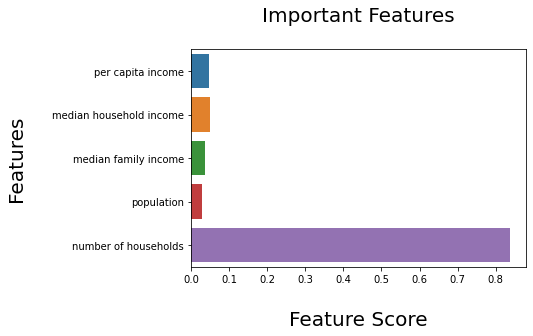

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline

sns.barplot(x=regressor.feature_importances_, y= features)
plt.xlabel('\nFeature Score', fontsize=20)
plt.ylabel('Features\n', fontsize=20)
plt.title('Important Features\n', fontsize=20)
plt.show()

The number of households was the [only] significant feature for the **Decision Tree Regressor** prediction.

The first **Linear Regression** model had a lower RMSE.